# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm

### Открытие csv файла

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')

Посмотрим на датафрейм, изучим его колонки

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


### Проверка на отсутствующие значения

In [4]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

Посмотрим на типы данных исходного датафрейма:

In [5]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

Определим количество строк в датафрейме и количество уникальных пользователей:

In [6]:
df.shape[0]

404770

In [7]:
df.user_id.nunique()

404770

Количество уникальных пользователей соответствует количеству строк в датафрейме. Можно сделать вывод, что каждая строка в датафрейме соответствует данным о конкретном пользователе.

### Разделение исходного датафрейма на Тестовую и Контрольную группы

In [8]:
control = df.query('testgroup == "a"')

In [9]:
control_payful = control.query('revenue > 0')

In [10]:
test = df.query('testgroup =="b"')

In [11]:
test_payful = test.query('revenue > 0')

<AxesSubplot:xlabel='testgroup', ylabel='user_id'>

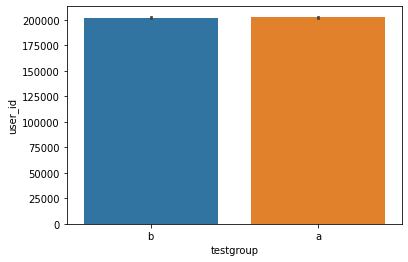

In [12]:
sns.barplot(data=df, x='testgroup', y='user_id')

Из графика видно, что количество людей в группах примерно одинаково.

### Подсчет разницы ARPPU

In [13]:
ARPPU_test = test_payful.revenue.sum()/test_payful.user_id.nunique()
ARPPU_control = control_payful.revenue.sum()/control_payful.user_id.nunique()

In [14]:
ARPPU_diff = "{0:.1f}%".format(ARPPU_test/ARPPU_control * 100)
ARPPU_diff

'112.7%'

Прибыль в тестовой группе на платящего пользователя больше на **12.7%**.

### Создание графика зависимости количества пользователей контрольной группы и их Revenue

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Revenue', ylabel='Density'>

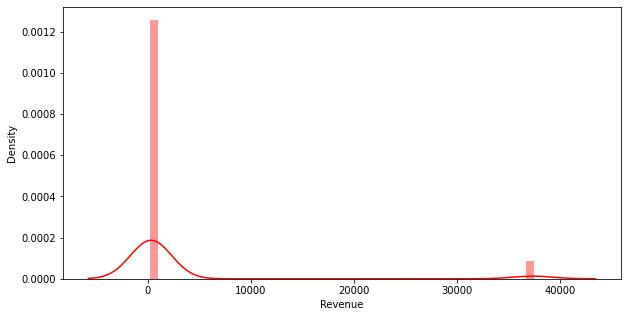

In [15]:
plt.figure(figsize=(10,5))
sns.distplot(control_payful.revenue, color="r", axlabel='Revenue')

Значения **Revenue** в контрольной группе имеют сильные выбросы. Это может обуславливаться неправильным сплитованием данных (очень лояльные пользователи попали лишь в контрольную группу), либо же ошибками логирования в данных. Так как у нас нет более подробных данных по каждой из групп, рассмотрим два случая: 

1. Данные выбросы явлются аномальными значениями.
2. Данные выбросы являются результатом отбора исправной системы сплитования.

In [16]:
control.query('revenue > 10000').user_id.count()

123

In [17]:
control.query('revenue > 10000').revenue.mean().round(2)

37319.12

В контрольной выборке **123** аномальных значения со средним revenue на пользователя **37319.12**.

### Создание графика зависимости количества пользователей тестовой группы и их Revenue

c:\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Revenue', ylabel='Density'>

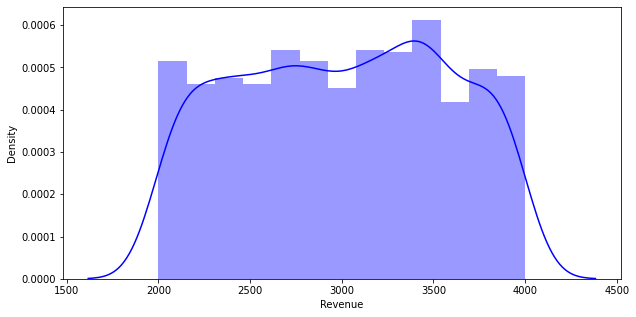

In [18]:
plt.figure(figsize=(10,5))
sns.distplot(test_payful.revenue,color="b", axlabel='Revenue')

### Оценка статзначимости разности распределений в тестовой и в контрольной группе, включающей выбросы

Поскольку распределение значений в группах отличается от нормального. Для определения статистической значимости между контрольной и тестовой группами будем использовать **критерий Манна-Уитни**:

In [19]:
stats.mannwhitneyu(control_payful.revenue, test_payful.revenue)


MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

**P-value < 0.05**, соответственно можем утверждать, что разница **ARPPU** между **тестовой** и **контрольной** группами **статистически значима**.

### Проверка гипотезы с помощью Bootstrap на платящих пользователях

In [20]:
 def get_bootstrap(
     data_column_1, 
     data_column_2, 
     boot_it=1000, 
     statistic=np.mean, 
     bootstrap_conf_level=0.95
):
    
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): 
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True 
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
   
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

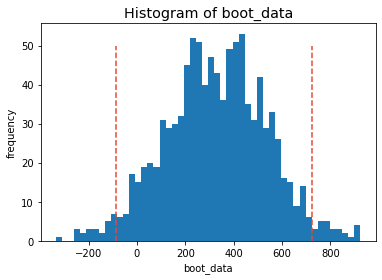

In [21]:
booted = get_bootstrap(test_payful.revenue, control_payful.revenue)

In [22]:
booted['ci']

,0
0.025,-86.798029
0.975,726.008766


In [23]:
booted['p_value']

0.11487253377377107

По гистограмме сверху видно, что **0** попадает в **95% доверительный интервал** между 2.5 перцентилем и 97.5 перцентилем. **P-value > 0.05**, что говорит **об отсутствии статистически значимых различий между группами А и B**. Различия в результате определения стат значимости с критерием Манна-Уитни можно объяснить тем, что **Bootstrap** работает методом сравнения средних значений признака в полученных выборках, а **критерий Манна-Уитни** ранжирует значения, поэтому выбросы при его использовании не так критичны.


### Отсеивание выбросов в контрольной группе (значения Revenue > 10000) и повтоорная проверка гипотезы с помощью критерия Манна-Уитни и метода Bootstrap

In [24]:
control_cleaned = control_payful.query('revenue < 10000')

In [25]:
stats.mannwhitneyu(control_cleaned.revenue, test_payful.revenue)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

По критерию Манна-Уитни **P-value < 0.05**, соответственно, можем утверждать, что разница **ARPPU** между **тестовой** и **контрольной** группой без выбросов **статистически значима**.

  0%|          | 0/1000 [00:00<?, ?it/s]

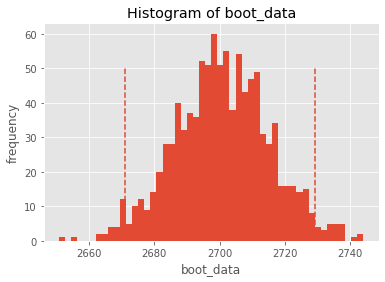

In [26]:
clean_booted = get_bootstrap(test_payful.revenue, control_cleaned.revenue)

In [27]:
clean_booted['p_value']

0.0

In [28]:
clean_booted['ci']

,0
0.025,2671.14597
0.975,2729.17108


Анализируя гистограмму результата, полученного методом **Bootstrap** видно, что после удаления из выборки выбросов, значение **P-value < 0.05**, а **0 не входит в 95% доверительный интервал**. Различия являются **статистически значимыми.**

### Сравнение ARPPU тестовой группы, с данными ARPPU контрольной группы без выбросов

In [29]:
ARPPU_cleaned = control_cleaned.revenue.sum()/control_cleaned.user_id.nunique()

In [30]:
ARPPU_diff_clean = "{0:.1f}%".format(ARPPU_test/ARPPU_cleaned * 100)
ARPPU_diff_clean

'993.1%'

Если убрать выбросы, то разница между **тестовой** группой и **контрольной**, составляет **993%**, что равно, примерно, **10 кратному увеличению ARPPU** при выборе тестового набора акционных предложений.

### Нахождение значения платящих пользователей и общего количества пользователей в каждой из выборок

In [31]:
payful_users_control = control_payful.shape[0]
payful_users_test = test_payful.shape[0]
users_control = control.shape[0] 
users_test = control.shape[0]

Посмотрим, значимо ли изменилось количество платящих пользователей в зависимости от группы. 

Это можно сделать, сранив категориальные переменные (**платит** или **не платит**) (**группа А** или **группа В**).

* **Н0:** взаимосвязи между предоставляемыми услугами и количеством платящих пользователями нет.
* **Н1:** предоставляемые услуги влияют на количество платящих пользователей.

In [32]:
stat, p, dof, expected = stats.chi2_contingency([[payful_users_control, payful_users_test],[users_control, users_test]])
p.round(3)

0.047

**P-value < 0.05**. **Отклоняем нулевую гипотезу**. Количество людей, пользующихся платными услугами продукта, **статистически значимо сократилось**. 

### Расчет CR

In [33]:
CR_test = payful_users_test/users_test

In [34]:
CR_control = payful_users_control/users_control

In [35]:
CR_diff = CR_test/CR_control * 100
round(CR_diff,2)

93.62

**CR тестовой** группы составляет **93.62%** от значения **контрольной**, соответственно, CR сократился на **6,38%**.

Посмотрим, повлияли ли выбросы на статистическую значимость количества платящих пользователей.

Получим значения размера выборки пользователей тратящих **менее 10000**:

In [36]:
payful_users_control_cleaned = control_cleaned.shape[0]
users_control_cleaned = control.query('revenue < 10000').shape[0]

In [37]:
stat, p, dof, expected = stats.chi2_contingency([[payful_users_control_cleaned, payful_users_test],[users_control_cleaned, users_test]])
p

0.9988111324554863

Выбросы также влияют на результат полученного распределения, в данном случае **P-value > 0.05**, что не позволяет отклонить **Н0** об отсутствии связи между предоставляемыми услугами и количеством платящих пользователей. 

### Выводы:
1. При проверке распределения прибыли, выявлено **123** аномальных значения со средней суммой покупки **37319.12**.
2. Статистическая значимость получаемых выводов сильно зависит от выявленных выбросов в контрольной группе, необходимо проверить систему сплитования и провести **А/А тесты**.
   
#### Рассмотрим два случая:
        
#### Если данные выбросы являются результатом отбора исправной системы сплитования:
           
* Нельзя утверждать о повышении **ARPPU** на **12%**, поскольку с помошью метода **Bootstrap** не удается добиться значения **P-value < 0.05**, не смотря на статистическую значимость **критерия Манна-Уитни** в данном случае. Это может быть обусловлено принципами работы критерия Манна-Уитни (поскольку в этом методе значения ранжируются, то двухмодальное распределение может давать более сильные различия, чем через **Bootstrap**, в котором делается многократная выборка средних значений. Как мы знаем, выбросы очень сильно искажают показания характеристики mean).
* При проверке гипотезы о зависимости количества платящих пользователей от группы были обнаружены статистически значимые различия. Переход на тестовый пакет услуг приводит к уменьшению платящих пользователей, а соответственно и к понижению конверсии **(CR)** на **6,38%** до уровня **93.62%** от контрольного значения.
* Поскольку увеличение **ARPPU** не является статистически значимым, а **CR** уменьшается, можно сделать заключение о том, что **контрольный набор акционных предложений является наилучшим**. 
        
#### Если данные выбросы являются аномальными значениями:
            
* Можно утверждать о статистически значимом повышении **ARPPU** на **993%**, поскольку и **критерий Манна-Уитни** и метод **Bootstrap** дают значения **P-value < 0.05**.
* При проверке гипотезы о зависимости количества платящих пользователей от группы статистически значимых различий **не обнаружено**. Зависимость между переходом на тестовый пакет услуг и количеством платящих пользователей **отсутствует**. **Тестовый пакет акций не влияет на конверсию (CR)** пользователей.
* Поскольку увеличение **ARPPU** на **993%** статистически значимо, а **CR** не изменяется, можно сделать заключение о том, что **тестовый набор акционных предложений является наилучшим и дает почти 10 кратный прирост прибыли**.
